In [4]:
from netCDF4 import Dataset

import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
with Dataset(os.path.join('data', 'wind_psl', 'pr.std.nc4'), "r", format="NETCDF4") as file:
    std = file['pr'][0].item()

 Commonly used threshold to define dry_days is 0.1 mm/day


In [6]:
threshold = 0.1

## Functions

### Units:
The output of edvae is precipitation_flux $\left[\frac{\text{kg}}{\text{m}^2 \text{s}}\right]$ divided by its standard deviation over all years and grid points.

In [7]:
def normalized_flux_to_mm_per_d(pr_norm_flux, std):
    return pr_norm_flux * std * 60 * 60 * 24
def mm_per_d_to_normalized_flux(mm_per_day, std):
    return mm_per_day / std / 60 / 60 / 24

In [8]:
def percentile_error(observed, downscaled, percentile):
    error = np.zeros(observed.shape[1:])
    for i in range(observed.shape[1]):
        for j in range(observed.shape[2]):
            wet_days = observed[:,i,j][observed[:,i,j] > threshold]
            downscaled_wet_days = downscaled[:,i,j][downscaled[:,i,j] > threshold]
            error[i,j] = np.percentile(downscaled_wet_days,percentile) - np.percentile(wet_days,percentile)
    return error


In [9]:
def mean_abs_percentile_error(observed, downscaled, percentile):
    return np.mean(np.abs(percentile_error(observed, downscaled, percentile)))

In [10]:
def read_data(path, margin):
    with Dataset(path, "r", format="NETCDF4") as file:
        pr = file['pr'][:,margin:-margin,margin:-margin]
        pr_recon = file['downscaled_pr_0'][:,margin:-margin,margin:-margin]
        pr_interpol = file['bilinear_downscaled_pr'][:,margin:-margin,margin:-margin]
        t = len(file['time'])
        # convert to mm/d
        pr = normalized_flux_to_mm_per_d(pr, std)
        pr_recon = normalized_flux_to_mm_per_d(pr_recon, std)
        pr_interpol = normalized_flux_to_mm_per_d(pr_interpol, std)
        
        return pr, pr_recon, pr_interpol, t

In [11]:
def print_percentile_errors(path, percentiles):
    total_recon_errors = []
    total_interpol_errors = []
    for filename in os.listdir(path):
        if filename.startswith('val.'):
            pr, pr_recon, pr_interpol, t = read_data(path=os.path.join(path, filename), margin=8)
            local_recon_errors = []
            local_interpol_errors = []
            print(filename)
            for percentile in percentiles:
                recon_error = mean_abs_percentile_error(pr, pr_recon, percentile)
                interpol_error = mean_abs_percentile_error(pr, pr_interpol, percentile)
                print("{}th percentile of edvae = {} \t bilinear interpolation = {}".
                      format(percentile, recon_error, interpol_error)) 
                local_recon_errors.append(recon_error)
                local_interpol_errors.append(interpol_error)
            total_recon_errors.append(local_recon_errors)
            total_interpol_errors.append(local_interpol_errors)
    average_recon = np.mean(total_recon_errors, 1)
    average_interpol = np.mean(total_interpol_errors, 1)
    print('--------------------------------------------------------------------------------')
    for i in range(len(percentiles)):
        print('average errors for {}th percentile of edvae = {}, bilinear interpolation = {}'.
              format(percentiles[i], average_recon[i], average_interpol[i]))
    return total_recon_errors, total_interpol_errors

In [12]:
def plot_percentile_errors(paths, area, percentiles, absolute=False):
    fig, axes = plt.subplots(len(percentiles), len(paths)+1, sharex=True, sharey=True, figsize = (20, 20))
    # plot pr and interpol_pr, set v_min, v_max to the pr max and min value
    pr, _, pr_interpol, _ = read_data(path=os.path.join(paths[0], area), margin=8)
    vmax = []
    for i in range(len(percentiles)):
        interpol_error = percentile_error(pr, pr_interpol, percentiles[i])
        
        vmax.append(np.abs(interpol_error).max())
        if absolute:
            axes[i,-1].imshow(np.abs(interpol_error), cmap=plt.get_cmap('bwr'),
                              vmin=-vmax[i], vmax=vmax[i])
        else:
            axes[i,-1].imshow(interpol_error, cmap=plt.get_cmap('bwr'),
                              vmin=-vmax[i], vmax=vmax[i])
        axes[i,-1].set_title('bilinear interpolated')
        axes[i,-1].set_ylabel('{}th percentile'.format(percentiles[i]), rotation=90, size='large')
    for j in range(len(paths)):
        _, pr_recon, _, _ = read_data(path=os.path.join(paths[j], area), margin=8)
        for i in range(len(percentiles)):
            if absolute:
                axes[i,j].imshow(np.abs(percentile_error(pr, pr_recon, percentiles[i])), cmap=plt.get_cmap('bwr'),
                                vmin=-vmax[i], vmax=vmax[i])
            else:
                axes[i,j].imshow(percentile_error(pr, pr_recon, percentiles[i]), cmap=plt.get_cmap('bwr'),
                                vmin=-vmax[i], vmax=vmax[i])
            axes[i,j].set_title(paths[j])
            axes[i,j].set_ylabel('{}th percentile'.format(percentiles[i]), rotation=90, size='large')
    fig.tight_layout()
    plt.show()
    
            

In [41]:
def plot_percentiles(paths, area, percentiles):
    fontsize = 24
    fig, axes = plt.subplots(len(percentiles), len(paths)+2, sharex=True, sharey=True, figsize = (16, 10))
    for ax, col in zip(axes[0], ['Observed', 'Bilinear Interpolated', 'Downscaled']):
        ax.set_title(col, fontsize=fontsize)

    for ax, percentile in zip(axes[:,0], percentiles):
        ax.set_ylabel('{}th Percentile'.format(percentile), rotation=90, fontsize=fontsize)
    # plot pr and interpol_pr, set v_min, v_max to the pr max and min value
    pr, _, pr_interpol, _ = read_data(path=os.path.join(paths[0], area), margin=8)
    vlims = []
    for i in range(len(percentiles)):
        pr_percentile = np.percentile(pr, percentiles[i], axis=0)
        vmin = pr_percentile.min()
        vmax = pr_percentile.max()
        vlims.append([vmin, vmax])
        
        axes[i,0].imshow(pr_percentile, cmap=plt.get_cmap('jet'), vmin=vmin, vmax=vmax)
        axes[i,1].imshow(np.percentile(pr_interpol, percentiles[i], axis=0), cmap=plt.get_cmap('jet'),
                          vmin=vmin, vmax=vmax)        
    for j in range(len(paths)):
        _, pr_recon, _, _ = read_data(path=os.path.join(paths[j], area), margin=8)
        for i in range(len(percentiles)):
            axes[i,j+2].imshow(np.percentile(pr_recon, percentiles[i], axis=0), cmap=plt.get_cmap('jet'),
                            vmin=vlims[i][0], vmax=vlims[i][1])
    fig.tight_layout()
    plt.show()
    
            

## Wet day distribution

In [45]:
paths = [ 'results/01_17_mse_128/val_1/','results/01_17_mse_256/val_7']
percentiles = [50, 95]
area = 'val.lat8_lon160.nc4'

In [47]:
for path in paths:
    print(path)
    print('----------------------------------------')
    print_percentile_errors(path=path, percentiles=percentiles)
    print('--------------------------------------------------------------')

results/01_17_mse_128/val_1/
----------------------------------------
val.lat48_lon120.nc4
50th percentile of edvae = 0.16735116936615668 	 bilinear interpolation = 0.18002620231709443
95th percentile of edvae = 0.7803668269421906 	 bilinear interpolation = 3.2889841597527267
val.lat88_lon600.nc4
50th percentile of edvae = 0.6653399571077898 	 bilinear interpolation = 0.9975581476464868
95th percentile of edvae = 2.274166153836993 	 bilinear interpolation = 5.61986677558161
val.lat8_lon80.nc4
50th percentile of edvae = 0.44429952453356236 	 bilinear interpolation = 0.8484246104490012
95th percentile of edvae = 4.766920107731127 	 bilinear interpolation = 9.22869996047811
val.lat88_lon560.nc4
50th percentile of edvae = 0.4635255600514938 	 bilinear interpolation = 0.5411593372409698
95th percentile of edvae = 2.746115956177526 	 bilinear interpolation = 4.094550354655073
val.lat48_lon320.nc4
50th percentile of edvae = 0.23178526782430708 	 bilinear interpolation = 0.5065226819133386
95t

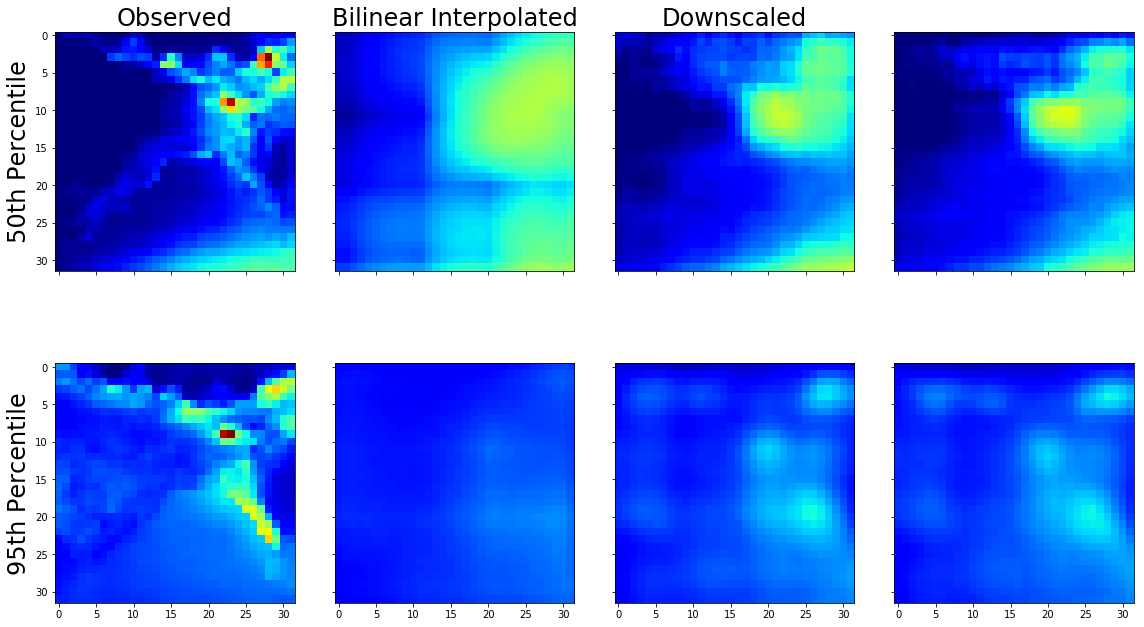

In [48]:
plot_percentiles(paths, area, percentiles)

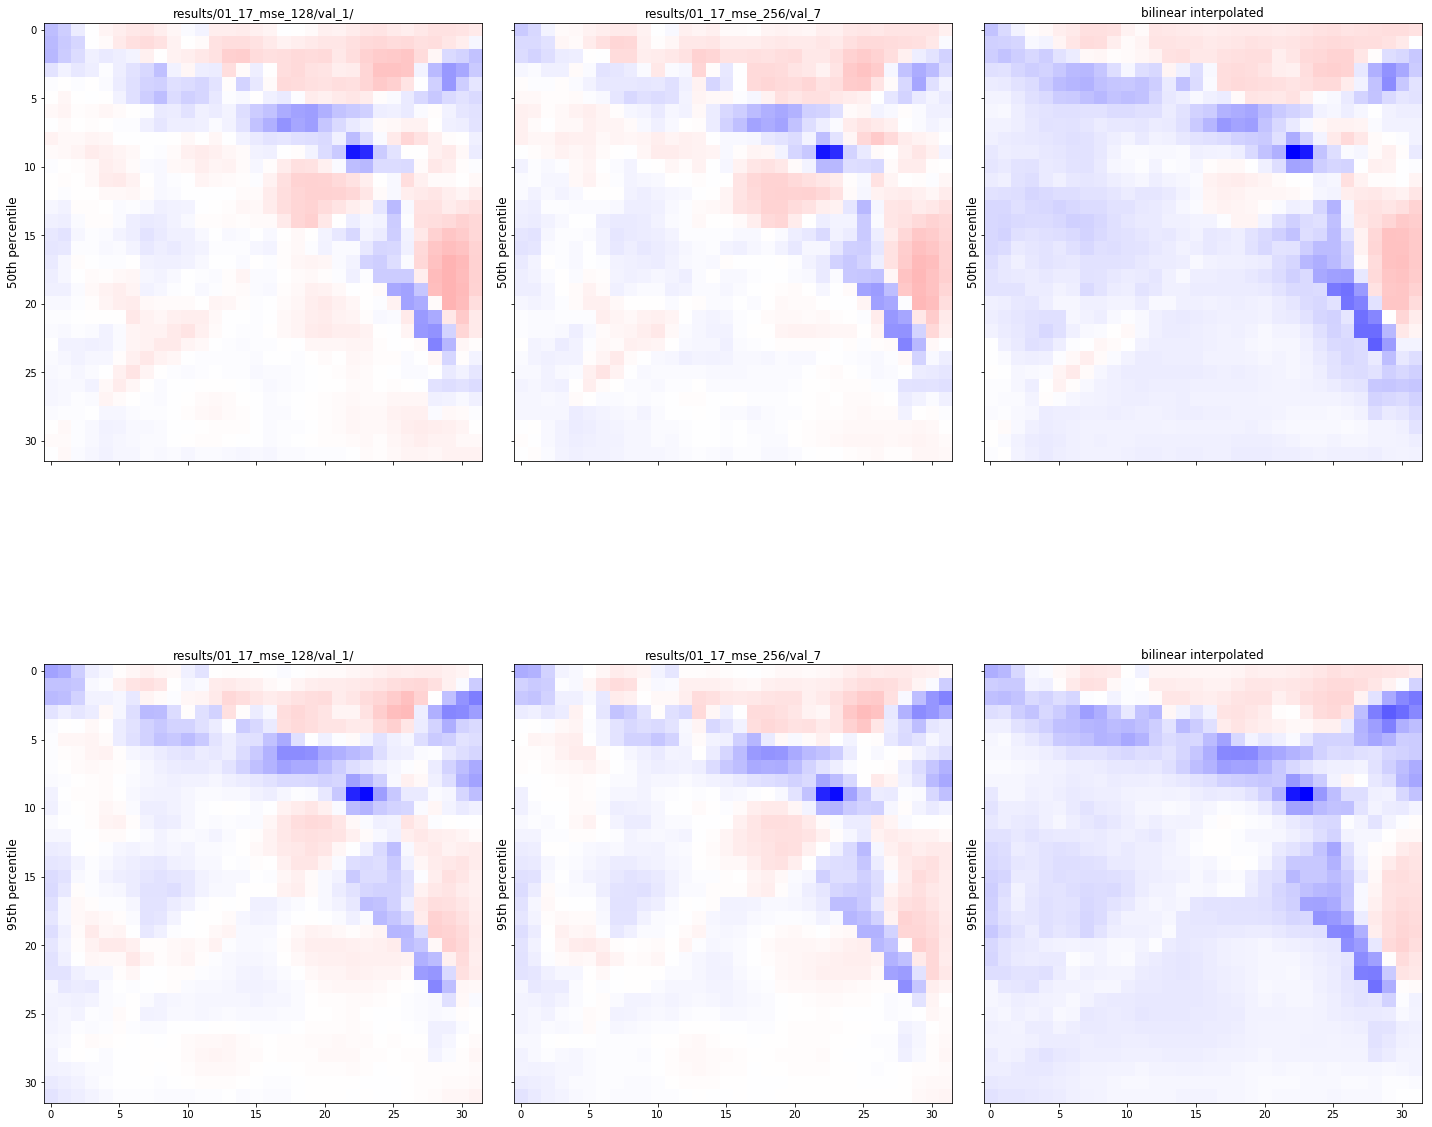

In [49]:
plot_percentile_errors(paths, area, percentiles)

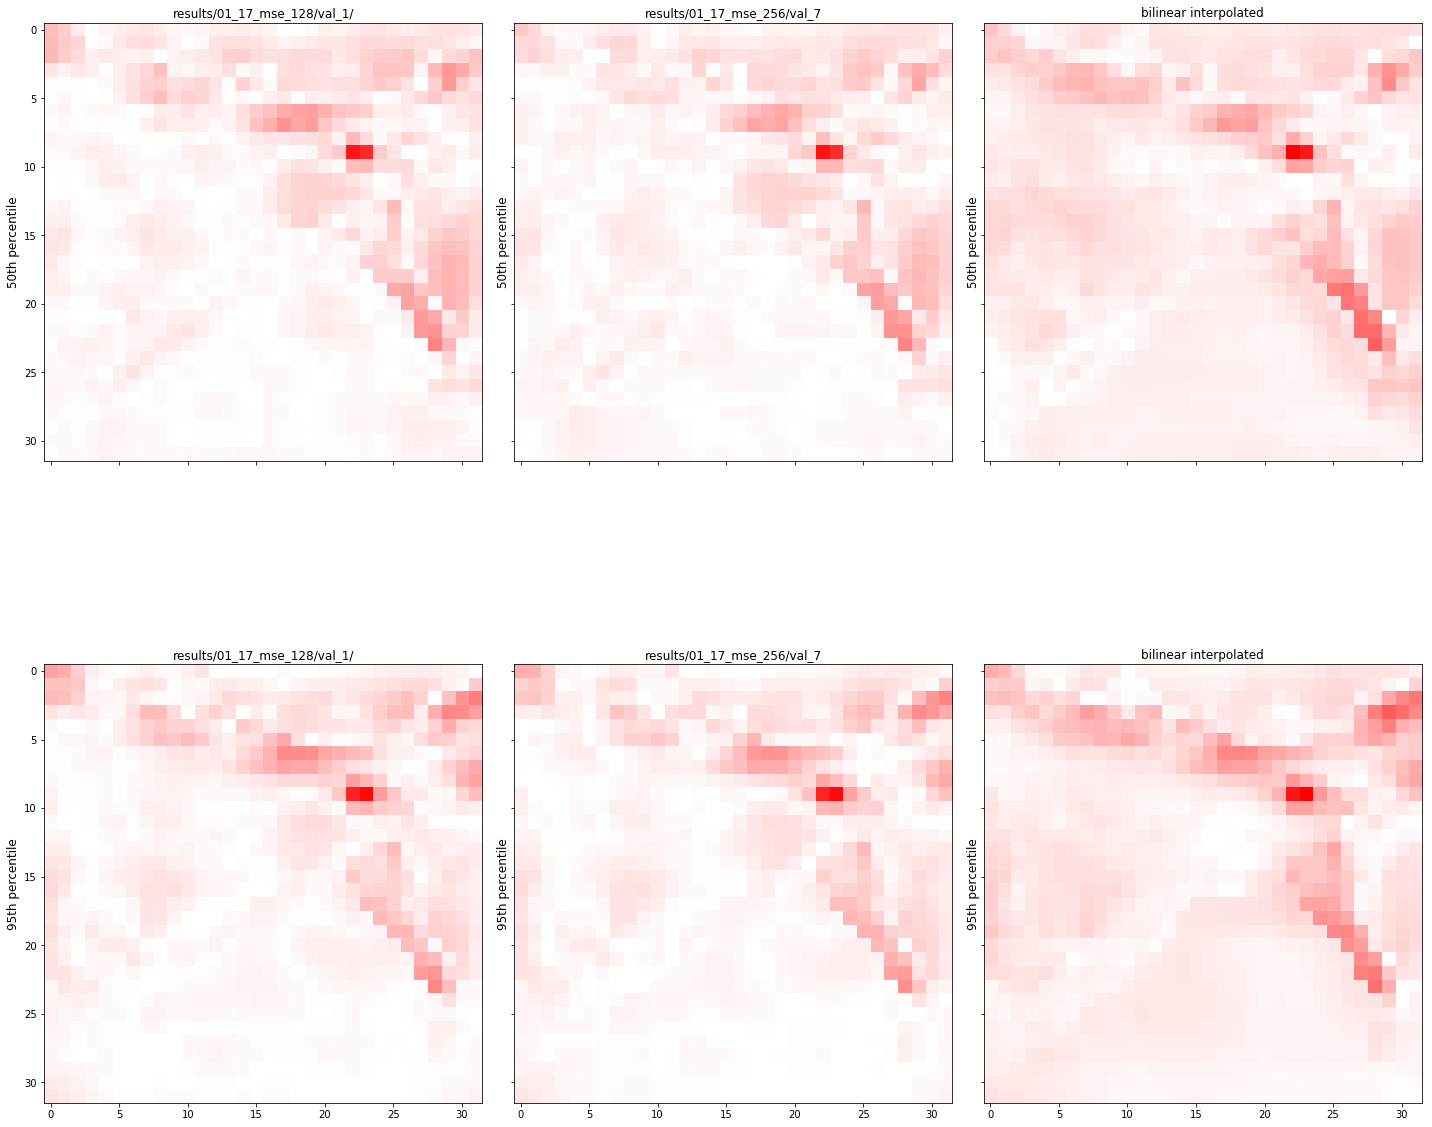

In [50]:
plot_percentile_errors(paths, area, percentiles, absolute=True)

## Dry day fraction

In [51]:
def plot_dry_d_error(paths, area):
    fig, axes = plt.subplots(2, len(paths)+1, sharex=True, sharey=True, figsize = (20, 20))
    # plot pr and interpol_pr, set v_min, v_max to the pr max and min value
    pr, _, pr_interpol, t = read_data(path=os.path.join(paths[0], area), margin=8)
    dry_d_frac = np.sum(pr <= 0.1,axis=0)/t
    interpol_dry_d_frac = np.sum(pr_interpol <= 0.1, axis=0)/t
    error_interpol_dry_d_frac = interpol_dry_d_frac - dry_d_frac
    vmax=max([error_interpol_dry_d_frac.min(), error_interpol_dry_d_frac.max()])
    # plot error
    axes[0,-1].imshow(error_interpol_dry_d_frac, cmap=plt.get_cmap('bwr'),
                     vmin=-1, vmax=1)
    axes[0,-1].set_title('bilinear interpolated')
    axes[0,-1].set_ylabel('error'.format(percentiles[i]), rotation=90, size='large')
    # plot abs error
    axes[1,-1].imshow(np.abs(error_interpol_dry_d_frac), cmap=plt.get_cmap('bwr'),
                     vmin=-1, vmax=1)
    axes[1,-1].set_title('bilinear interpolated')
    axes[1,-1].set_ylabel('abs error'.format(percentiles[i]), rotation=90, size='large')
    for j in range(len(paths)):
        # compute dry day frequences
        _, pr_recon, _,  _= read_data(path=os.path.join(paths[j], area), margin=8)
        recon_dry_d_frac = np.sum(pr_recon <= 0.1, axis=0)/t
        error_recon_dry_d_frac = recon_dry_d_frac - dry_d_frac
        # plot
        axes[0,j].imshow(error_recon_dry_d_frac, cmap=plt.get_cmap('bwr'),
                         vmin=-1, vmax=1)
        axes[0,j].set_title(paths[j])
        axes[0,j].set_ylabel('error', rotation=90, size='large')
        # plot abs error
        axes[1,j].imshow(np.abs(error_recon_dry_d_frac), cmap=plt.get_cmap('bwr'),
                         vmin=-1, vmax=1)
        axes[1,j].set_title(paths[j])
        axes[1,j].set_ylabel('abs error', rotation=90, size='large')        
    fig.tight_layout()
    plt.show()

In [52]:
def plot_dry_d(paths, area):
    fig, axes = plt.subplots(1, len(paths)+2, sharex=True, sharey=True, figsize = (20, 20))
    # plot pr and interpol_pr, set v_min, v_max to the pr max and min value
    pr, _, pr_interpol, t = read_data(path=os.path.join(paths[0], area), margin=8)
    dry_d_frac = np.sum(pr <= 0.1,axis=0)/t
    interpol_dry_d_frac = np.sum(pr_interpol <= 0.1, axis=0)/t
    # plot
    axes[-2].imshow(interpol_dry_d_frac, cmap=plt.get_cmap('bwr'),
                     vmin=-1, vmax=1)
    axes[-2].set_title('bilinear interpolated')
    axes[-1].imshow(dry_d_frac, cmap=plt.get_cmap('bwr'),
                     vmin=-1, vmax=1)
    axes[-1].set_title('observed')
    for j in range(len(paths)):
        # compute dry day frequences
        _, pr_recon, _,  _= read_data(path=os.path.join(paths[j], area), margin=8)
        recon_dry_d_frac = np.sum(pr_recon <= 0.1, axis=0)/t
        # plot
        axes[j].imshow(recon_dry_d_frac, cmap=plt.get_cmap('bwr'),
                         vmin=-1, vmax=1)
        axes[j].set_title(paths[j])
        axes[j].set_ylabel('dry day frequency error', rotation=90, size='large')
    fig.tight_layout()
    plt.show()

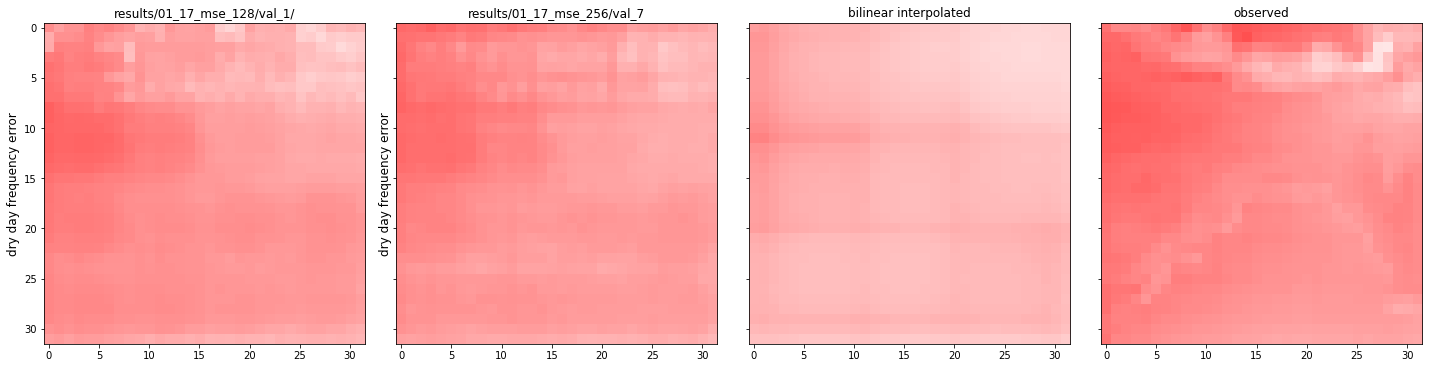

In [53]:
plot_dry_d(paths=paths, area=area)

NameError: name 'i' is not defined

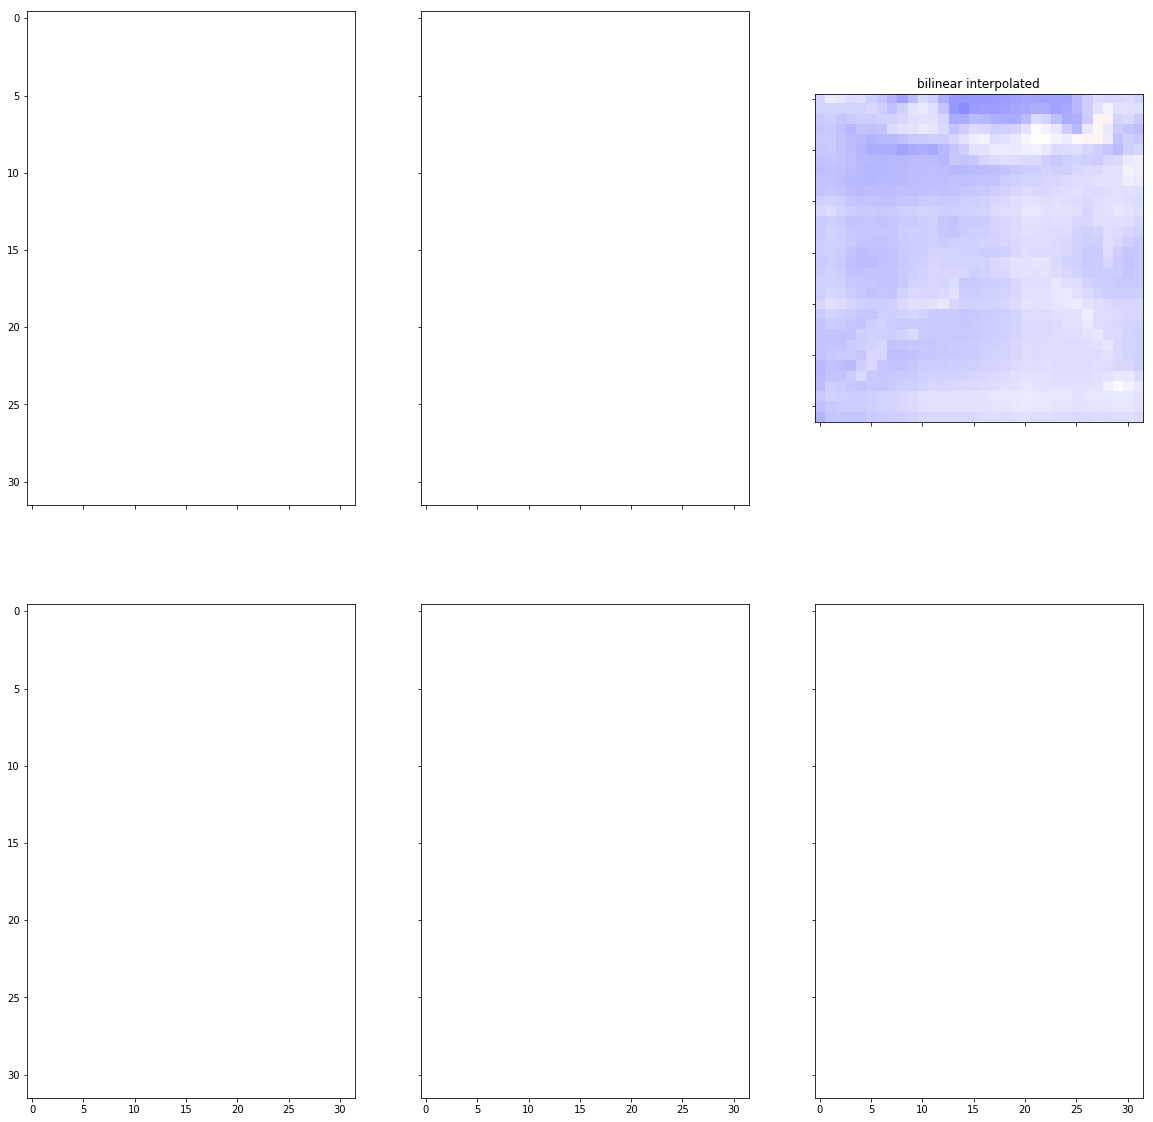

In [54]:
plot_dry_d_error(paths=paths, area=area)

In [222]:
pr, _, pr_interpol, t = read_data(path=os.path.join(paths[0], area), margin=8)
dry_d_frac = np.sum(pr <= 0.1,axis=0)/t
interpol_dry_d_frac = np.sum(pr_interpol <= 0.1, axis=0)/t
error_interpol_dry_d_frac = interpol_dry_d_frac - dry_d_frac
recon_dry_d_frac = np.sum(pr_recon <= 0.1, axis=0)/t
error_recon_dry_d_frac = recon_dry_d_frac - dry_d_frac

In [223]:
np.mean(np.abs(error_interpol_dry_d_frac))

0.1796874236105679

In [224]:

np.mean(np.abs(error_recon_dry_d_frac))

0.23805597756472935

In [133]:
a = np.array([np.arange(0, 1, .1)])

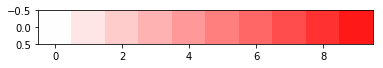

In [134]:
plt.imshow(a, cmap=plt.get_cmap('bwr'),vmin=-1, vmax=1)